In [1]:
%cd ../
%matplotlib inline

/home/eli/AnacondaProjects/HTFATorch


In [2]:
# import dependencies
import logging
import htfa_torch.tfa as TFA
import htfa_torch.utils as utils

In [3]:
tfa = TFA.TopographicalFactorAnalysis('data/pieman_data/sub-001-task-intact1.nii', num_factors=25)

In [4]:
losses = tfa.train(num_steps=200, log_level=logging.INFO, batch_size=tfa.voxel_activations.shape[0], num_samples=1)

03/19/2018 11:40:26 [Epoch 1] (1634ms) Posterior free-energy 1.15435878e+10
03/19/2018 11:40:26 [Epoch 2] (194ms) Posterior free-energy 1.56450406e+10
03/19/2018 11:40:26 [Epoch 3] (190ms) Posterior free-energy 1.73232497e+10
03/19/2018 11:40:26 [Epoch 4] (190ms) Posterior free-energy 1.33626225e+10
03/19/2018 11:40:27 [Epoch 5] (191ms) Posterior free-energy 5.13827891e+09
03/19/2018 11:40:27 [Epoch 6] (190ms) Posterior free-energy 1.22289674e+10
03/19/2018 11:40:27 [Epoch 7] (189ms) Posterior free-energy 7.26066125e+09
03/19/2018 11:40:27 [Epoch 8] (190ms) Posterior free-energy 5.90548378e+09
03/19/2018 11:40:27 [Epoch 9] (188ms) Posterior free-energy 7.63265126e+09
03/19/2018 11:40:28 [Epoch 10] (192ms) Posterior free-energy 6.32587059e+09
03/19/2018 11:40:28 [Epoch 11] (189ms) Posterior free-energy 9.67682458e+09
03/19/2018 11:40:28 [Epoch 12] (189ms) Posterior free-energy 3.81196902e+09
03/19/2018 11:40:28 [Epoch 13] (189ms) Posterior free-energy 5.40634214e+09
03/19/2018 11:40:28 

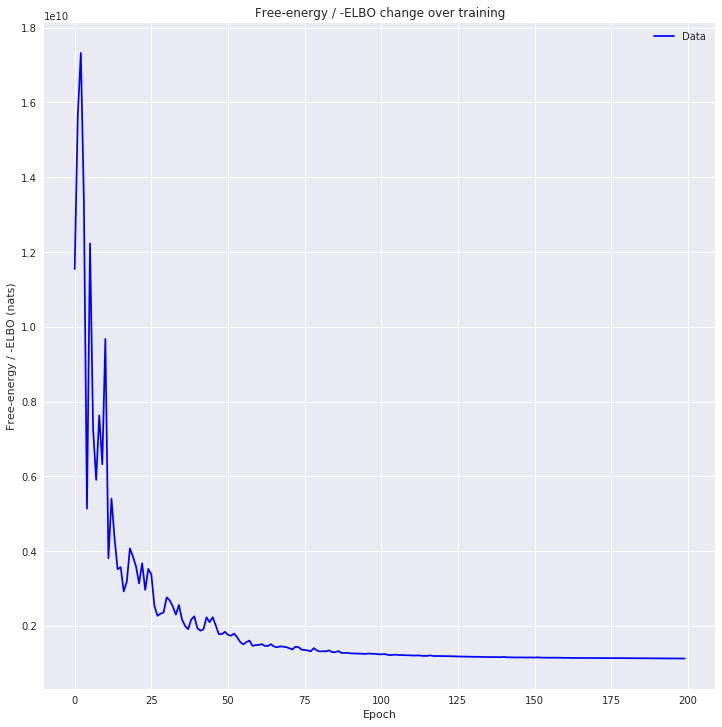

03/19/2018 11:41:08 Reconstruction Error (Frobenius Norm): 4.84060596e+03
03/19/2018 11:41:08 {'weights': array([[-0.5286352 ,  1.9576826 ,  1.0502251 , ...,  0.58114296,
        -2.1872904 ,  0.6722803 ],
       [-1.5339456 ,  0.4663415 ,  2.176583  , ...,  0.262368  ,
         0.38519138,  1.5598017 ],
       [-2.1438906 ,  0.26519305,  1.9254873 , ..., -1.3615234 ,
         0.86039937,  1.8350852 ],
       ...,
       [-4.334775  ,  0.65367115,  1.465351  , ..., -0.85519123,
         0.12142079,  0.40092584],
       [-4.7792487 ,  0.17395201,  2.7821548 , ..., -0.5415258 ,
        -0.44105646, -0.66858596],
       [-5.762428  ,  0.80494666,  4.3784633 , ...,  2.0558195 ,
         0.6223471 , -2.2492242 ]], dtype=float32), 'factors': array([[2.62269727e-03, 2.79178820e-03, 2.95263436e-03, ...,
        2.50894460e-03, 2.81244097e-03, 2.97972816e-03],
       [1.04869971e-04, 1.01719386e-04, 9.77142336e-05, ...,
        5.83471119e-01, 6.11448169e-01, 5.67471683e-01],
       [6.53034018

In [5]:
utils.plot_losses(losses)

results = tfa.results()
logging.info(results)

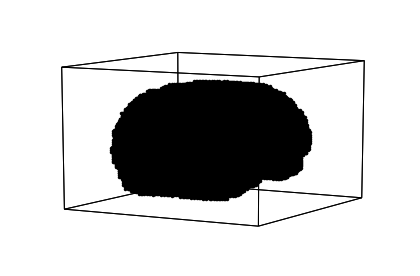

03/19/2018 11:41:15 Reconstruction Error (Frobenius Norm): 4.83675000e+03


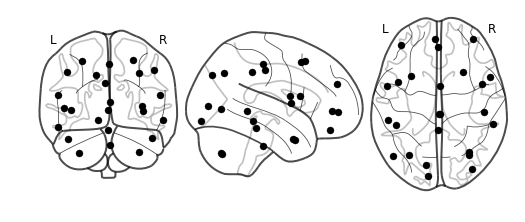

In [6]:
tfa.plot_voxels()
tfa.plot_factor_centers()

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


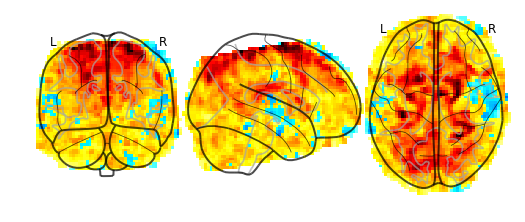

03/19/2018 11:41:23 Reconstruction Error (Frobenius Norm): 4.83781689e+03


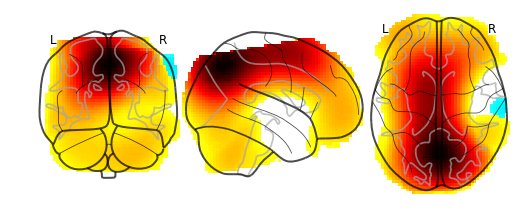

In [7]:
tfa.plot_original_brain()
tfa.plot_reconstruction()

03/19/2018 11:42:01 Reconstruction Error (Frobenius Norm): 4.83658838e+03


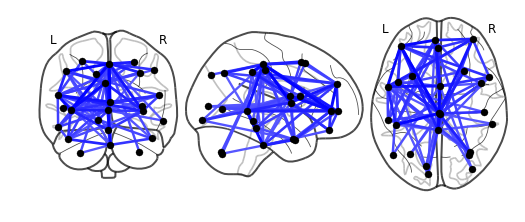

In [8]:
tfa.plot_connectome()